In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plot_series(time, series, format = '-', start = 0, end = None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    
def trend(time, slope = 0):
    return time * slope

def seasonal_pattern(season_time):
    return np.where(season_time < 0.4, np.cos(season_time * 2 * np.pi), 1 / np.exp(season_time * 4))

def seasonality(time, period, amplitude = 1, phase = 0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise (time, noise_level = 1, seed = None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype = 'float32')
baseline = 10
series = trend(time, 0.1)
slope = 0.09
amplitude = 20
period = 365
noise_level = 5

series = baseline + trend(time, slope) + seasonality(time, period, amplitude = amplitude)

series += noise(time, noise_level = noise_level, seed = 42)

split_time = 1000
train_time = time[:split_time]
train_x = series[:split_time]
valid_time = time[split_time:]
valid_x = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [3]:
def window_dataset(series, window_size, batch_size, shuffle_buffer_size):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift = 1, drop_remainder = True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer_size).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [4]:
dataset = window_dataset(train_x, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation = 'relu', input_shape = [window_size]),
    tf.keras.layers.Dense(10, activation = 'relu'),
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch/20))

optimizer = tf.keras.optimizers.SGD(lr = 1e-8, momentum = 0.9)

model.compile(optimizer = optimizer, loss = 'mse')

history = model.fit(dataset, epochs = 100, callbacks = [lr_schedule])

Epoch 1/100
31/31 [==============================] - 0s 1ms/step - loss: 2139.7351 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 0s 903us/step - loss: 600.0668 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 0s 844us/step - loss: 145.9634 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 0s 912us/step - loss: 65.1575 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 0s 793us/step - loss: 56.5106 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 0s 839us/step - loss: 55.9568 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 0s 822us/step - loss: 55.8552 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 0s 1ms/step - loss: 55.8208 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 0s 779us/step - loss: 55.7773 - lr: 2.5119e-08
Epoch 10/100
31/31 [==============================] - 0s 714us/step - loss: 55.7172 - lr: 2.8184e-08

31/31 [==============================] - 0s 807us/step - loss: 716.3693 - lr: 1.1220e-04
Epoch 83/100
31/31 [==============================] - 0s 751us/step - loss: 726.3476 - lr: 1.2589e-04
Epoch 84/100
31/31 [==============================] - 0s 740us/step - loss: 727.2457 - lr: 1.4125e-04
Epoch 85/100
31/31 [==============================] - 0s 732us/step - loss: 719.2890 - lr: 1.5849e-04
Epoch 86/100
31/31 [==============================] - 0s 751us/step - loss: 725.0972 - lr: 1.7783e-04
Epoch 87/100
31/31 [==============================] - 0s 778us/step - loss: 720.3706 - lr: 1.9953e-04
Epoch 88/100
31/31 [==============================] - 0s 747us/step - loss: 729.5750 - lr: 2.2387e-04
Epoch 89/100
31/31 [==============================] - 0s 719us/step - loss: 730.1763 - lr: 2.5119e-04
Epoch 90/100
31/31 [==============================] - 0s 750us/step - loss: 720.0790 - lr: 2.8184e-04
Epoch 91/100
31/31 [==============================] - 0s 816us/step - loss: 719.1254 - lr: 3.16

(1e-08, 0.001, 0.0, 300.0)

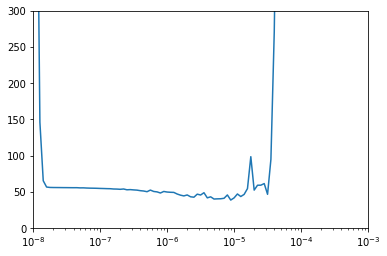

In [5]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

In [6]:
window_size = 30
dataset = window_dataset(train_x, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr=8e-6, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=500, verbose=1)

Epoch 1/500
31/31 [==============================] - 0s 804us/step - loss: 887.7895
Epoch 2/500
31/31 [==============================] - 0s 710us/step - loss: 50.0950
Epoch 3/500
31/31 [==============================] - 0s 747us/step - loss: 45.2602
Epoch 4/500
31/31 [==============================] - 0s 788us/step - loss: 37.7003
Epoch 5/500
31/31 [==============================] - 0s 730us/step - loss: 43.1546
Epoch 6/500
31/31 [==============================] - 0s 734us/step - loss: 37.4005
Epoch 7/500
31/31 [==============================] - 0s 739us/step - loss: 41.9933
Epoch 8/500
31/31 [==============================] - 0s 776us/step - loss: 45.0415
Epoch 9/500
31/31 [==============================] - 0s 810us/step - loss: 38.8873
Epoch 10/500
31/31 [==============================] - 0s 741us/step - loss: 36.6908
Epoch 11/500
31/31 [==============================] - 0s 726us/step - loss: 40.1814
Epoch 12/500
31/31 [==============================] - 0s 799us/step - loss: 35.6801


31/31 [==============================] - 0s 986us/step - loss: 34.9510
Epoch 99/500
31/31 [==============================] - 0s 782us/step - loss: 34.6324
Epoch 100/500
31/31 [==============================] - 0s 808us/step - loss: 47.1288
Epoch 101/500
31/31 [==============================] - 0s 811us/step - loss: 39.0228
Epoch 102/500
31/31 [==============================] - 0s 791us/step - loss: 34.7652
Epoch 103/500
31/31 [==============================] - 0s 807us/step - loss: 38.9913
Epoch 104/500
31/31 [==============================] - 0s 791us/step - loss: 33.6261
Epoch 105/500
31/31 [==============================] - 0s 810us/step - loss: 33.8254
Epoch 106/500
31/31 [==============================] - 0s 802us/step - loss: 33.7213
Epoch 107/500
31/31 [==============================] - 0s 927us/step - loss: 32.6278
Epoch 108/500
31/31 [==============================] - 0s 983us/step - loss: 32.2457
Epoch 109/500
31/31 [==============================] - 0s 1ms/step - loss: 33.49

31/31 [==============================] - 0s 777us/step - loss: 34.4095
Epoch 195/500
31/31 [==============================] - 0s 881us/step - loss: 33.3404
Epoch 196/500
31/31 [==============================] - 0s 769us/step - loss: 37.0347
Epoch 197/500
31/31 [==============================] - 0s 827us/step - loss: 33.7874
Epoch 198/500
31/31 [==============================] - 0s 850us/step - loss: 38.3671
Epoch 199/500
31/31 [==============================] - 0s 817us/step - loss: 32.7070
Epoch 200/500
31/31 [==============================] - 0s 784us/step - loss: 35.9641
Epoch 201/500
31/31 [==============================] - 0s 810us/step - loss: 32.1681
Epoch 202/500
31/31 [==============================] - 0s 823us/step - loss: 34.0246
Epoch 203/500
31/31 [==============================] - 0s 803us/step - loss: 33.1597
Epoch 204/500
31/31 [==============================] - 0s 772us/step - loss: 33.3141
Epoch 205/500
31/31 [==============================] - 0s 786us/step - loss: 37

31/31 [==============================] - 0s 746us/step - loss: 33.1396
Epoch 291/500
31/31 [==============================] - 0s 783us/step - loss: 30.5187
Epoch 292/500
31/31 [==============================] - 0s 742us/step - loss: 30.1500
Epoch 293/500
31/31 [==============================] - 0s 798us/step - loss: 31.1610
Epoch 294/500
31/31 [==============================] - 0s 758us/step - loss: 30.9408
Epoch 295/500
31/31 [==============================] - 0s 739us/step - loss: 30.9984
Epoch 296/500
31/31 [==============================] - 0s 748us/step - loss: 31.0076
Epoch 297/500
31/31 [==============================] - 0s 742us/step - loss: 31.5701
Epoch 298/500
31/31 [==============================] - 0s 750us/step - loss: 31.6927
Epoch 299/500
31/31 [==============================] - 0s 736us/step - loss: 33.5907
Epoch 300/500
31/31 [==============================] - 0s 751us/step - loss: 39.1365
Epoch 301/500
31/31 [==============================] - 0s 795us/step - loss: 33

31/31 [==============================] - 0s 783us/step - loss: 38.7695
Epoch 387/500
31/31 [==============================] - 0s 764us/step - loss: 32.9059
Epoch 388/500
31/31 [==============================] - 0s 762us/step - loss: 31.0648
Epoch 389/500
31/31 [==============================] - 0s 958us/step - loss: 31.7073
Epoch 390/500
31/31 [==============================] - 0s 798us/step - loss: 32.3550
Epoch 391/500
31/31 [==============================] - 0s 750us/step - loss: 30.4733
Epoch 392/500
31/31 [==============================] - 0s 783us/step - loss: 31.8329
Epoch 393/500
31/31 [==============================] - 0s 820us/step - loss: 33.3820
Epoch 394/500
31/31 [==============================] - 0s 826us/step - loss: 31.1670
Epoch 395/500
31/31 [==============================] - 0s 773us/step - loss: 33.9420
Epoch 396/500
31/31 [==============================] - 0s 784us/step - loss: 35.2167
Epoch 397/500
31/31 [==============================] - 0s 823us/step - loss: 34

31/31 [==============================] - 0s 920us/step - loss: 31.8028
Epoch 483/500
31/31 [==============================] - 0s 890us/step - loss: 30.6428
Epoch 484/500
31/31 [==============================] - 0s 862us/step - loss: 38.3135
Epoch 485/500
31/31 [==============================] - 0s 829us/step - loss: 30.6319
Epoch 486/500
31/31 [==============================] - 0s 821us/step - loss: 31.9214
Epoch 487/500
31/31 [==============================] - 0s 860us/step - loss: 34.6038
Epoch 488/500
31/31 [==============================] - 0s 946us/step - loss: 31.9619
Epoch 489/500
31/31 [==============================] - 0s 818us/step - loss: 31.0474
Epoch 490/500
31/31 [==============================] - 0s 840us/step - loss: 37.3502
Epoch 491/500
31/31 [==============================] - 0s 839us/step - loss: 32.7070
Epoch 492/500
31/31 [==============================] - 0s 861us/step - loss: 32.8932
Epoch 493/500
31/31 [==============================] - 0s 894us/step - loss: 34

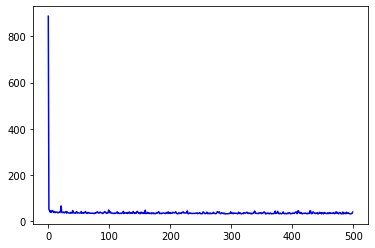

In [7]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

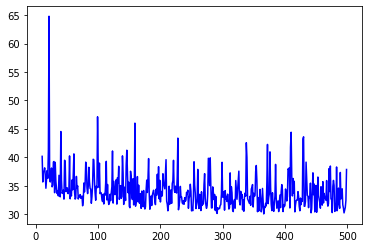

In [9]:
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
#print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

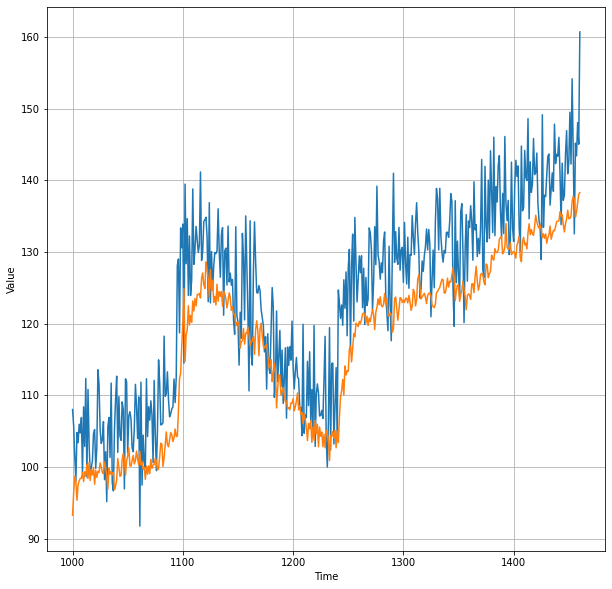

In [11]:
forcast = []

for time in range(len(series) - window_size):
    forcast.append(model.predict(series[time:time + window_size][np.newaxis]))
    
forcast = forcast[split_time - window_size :]
results = np.array(forcast)[:, 0, 0]

plt.figure(figsize = (10,10))

plot_series(valid_time, valid_x)
plot_series(valid_time, results)

In [12]:
print(tf.keras.metrics.mean_absolute_error(valid_x, results).numpy())

7.0148435
